# Decision Tree : Regression - Medical Insrurance Dataset

In [1]:
import numpy as np
import pandas as pd


from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


import pickle
import json

# Problem Statement

In [2]:
# To predict the charges required for medical insurance using Decision Tree regression problem.

# Data Gathering

In [3]:
df=pd.read_csv("medical_insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


age            AxesSubplot(0.125,0.125;0.168478x0.755)
bmi         AxesSubplot(0.327174,0.125;0.168478x0.755)
children    AxesSubplot(0.529348,0.125;0.168478x0.755)
charges     AxesSubplot(0.731522,0.125;0.168478x0.755)
dtype: object

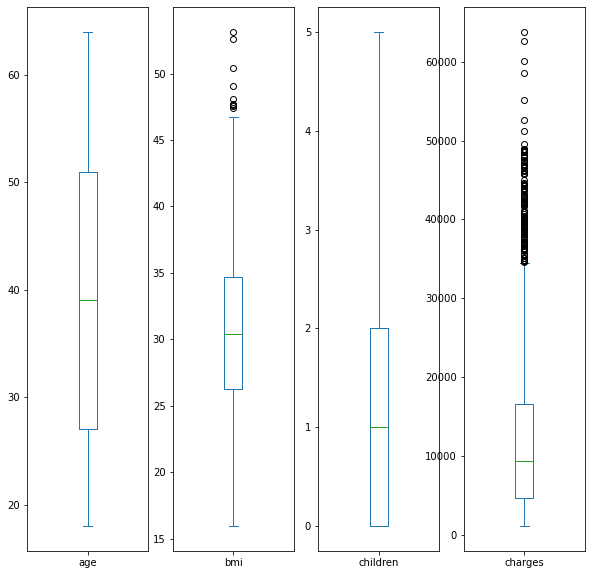

In [5]:
df.plot(kind='box',subplots=True,figsize=(10,10))

# Feature Engineering

In [6]:
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [7]:
df['sex'].replace({'male':0,'female':1},inplace=True)
sex_values={'male':0,'female':1}

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 73.3+ KB


In [9]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [10]:
df['smoker'].replace({'no':1,'yes':0},inplace=True)
smoker_values={'no':1,'yes':0}

In [11]:
df=pd.get_dummies(df,columns=['region'])
df

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,0,16884.92400,0,0,0,1
1,18,0,33.770,1,1,1725.55230,0,0,1,0
2,28,0,33.000,3,1,4449.46200,0,0,1,0
3,33,0,22.705,0,1,21984.47061,0,1,0,0
4,32,0,28.880,0,1,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,1,10600.54830,0,1,0,0
1334,18,1,31.920,0,1,2205.98080,1,0,0,0
1335,18,1,36.850,0,1,1629.83350,0,0,1,0
1336,21,1,25.800,0,1,2007.94500,0,0,0,1


# Imputation of Outliers

<AxesSubplot:xlabel='age'>

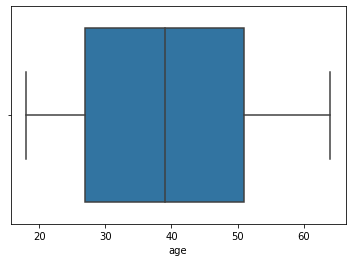

In [12]:
sns.boxplot(x=df['age'])

<AxesSubplot:xlabel='bmi'>

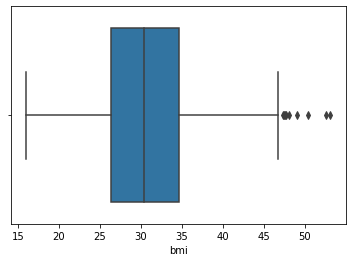

In [13]:
sns.boxplot(x=df['bmi'])

In [14]:
q1=df['bmi'].quantile(0.25)
q3=df['bmi'].quantile(0.75)

iqr=q3-q1
upper_tail=q3 + (1.5 * iqr)
lower_tail=q1 - (1.5 * iqr)

print("Q1 :",q1)
print("Q3 :",q3)
print("Upper_tail :",upper_tail)
print("Lower_tail :",lower_tail)

median= df['bmi'].loc[(df['bmi'] > lower_tail) & (df['bmi'] < upper_tail)].median()


Q1 : 26.29625
Q3 : 34.69375
Upper_tail : 47.290000000000006
Lower_tail : 13.7


<AxesSubplot:xlabel='bmi'>

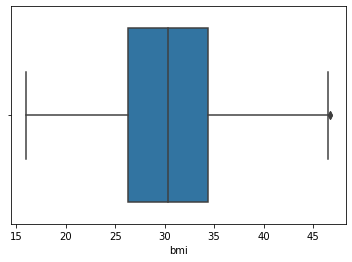

In [15]:
df['bmi'].loc[(df['bmi'] < lower_tail) | (df['bmi'] > upper_tail)] = median
sns.boxplot(x=df['bmi'])

# Feature Selection

# 1. Linearity

In [16]:
r=df.corr()[['charges']]
r

,charges
age,0.299008
sex,-0.057292
bmi,0.190559
children,0.067998
smoker,-0.787251
charges,1.000000
region_northeast,0.006349
region_northwest,-0.039905
region_southeast,0.073982
region_southwest,-0.043210


<AxesSubplot:>

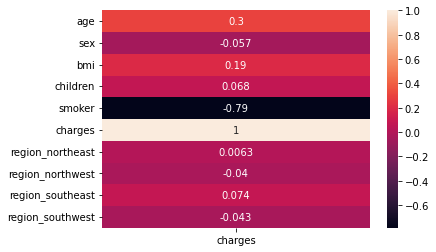

In [17]:
sns.heatmap(r,annot=True)

# 2. Multicolinearity

In [18]:
df1=df.drop('charges',axis=1)
df1

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,0,0,0,0,1
1,18,0,33.770,1,1,0,0,1,0
2,28,0,33.000,3,1,0,0,1,0
3,33,0,22.705,0,1,0,1,0,0
4,32,0,28.880,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,1,0,1,0,0
1334,18,1,31.920,0,1,1,0,0,0
1335,18,1,36.850,0,1,0,0,1,0
1336,21,1,25.800,0,1,0,0,0,1


In [19]:
vif_list=[]

for i in range(df1.shape[1]):
    vif=variance_inflation_factor(df1,i)
    vif_list.append(vif)
    
print(vif_list)

[1.017809417910381, 1.0083363120665887, 1.0976208164650705, 1.0041377808771532, 1.012255281333564, 9.69553140506988, 9.850390627142646, 12.555307778940216, 10.434876458223059]


<AxesSubplot:>

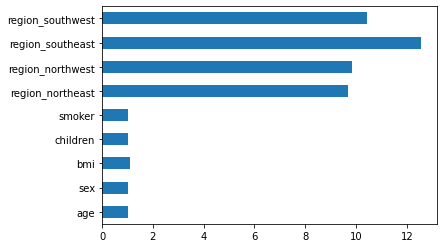

In [20]:
s=pd.Series(vif_list,index=df1.columns)
s.plot(kind='barh' )

# Model Building

In [21]:
x=df.drop('charges',axis=1)
y=df['charges']

# Train Test Split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=7)
x_train

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
1317,18,0,30.300,0,1,0,0,1,0
794,39,1,31.920,2,1,0,1,0,0
680,21,1,17.400,1,1,0,0,0,1
795,27,0,28.500,0,0,0,1,0,0
887,36,1,30.020,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
211,40,0,30.875,4,1,0,1,0,0
502,51,0,23.210,1,0,0,0,1,0
537,46,1,30.200,2,1,0,0,0,1
1220,30,1,21.945,1,1,1,0,0,0


# Model Training

In [23]:
decisiontree_medical_model = DecisionTreeRegressor()
decisiontree_medical_model.fit(x_train,y_train)

DecisionTreeRegressor()

# Model Evaluation

In [24]:
# Training accuracy
y_pred_train = decisiontree_medical_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :", mse)
print("*"*50)

rmse = np.sqrt(mse)
print("RMSE :", rmse)
print("*"*50)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE :", mae)
print("*"*50)

r2_value = r2_score(y_train, y_pred_train)
print("R2 Score :", r2_value)

MSE : 244239.55438233944
**************************************************
RMSE : 494.20598375812835
**************************************************
MAE : 29.572515327102803
**************************************************
R2 Score : 0.9982937723923396


In [25]:
# Testing accuracy
y_pred = decisiontree_medical_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :", mse)
print("*"*50)

rmse = np.sqrt(mse)
print("RMSE :", rmse)
print("*"*50)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :", mae)
print("*"*50)

r2_value = r2_score(y_test, y_pred)
print("R2 Score :", r2_value)

MSE : 41582411.10461836
**************************************************
RMSE : 6448.442533249277
**************************************************
MAE : 2946.6835372574624
**************************************************
R2 Score : 0.7400835811549413


#### 1st Model Accuracy after fitting DecisionTreeRegressor()
##### Training Accuracy = 99.82% 
#### Testing Accuracy = 73.24%

# Hyperparameter Tunning

In [26]:
import time
t1 = time.time()

dt_model = DecisionTreeRegressor(random_state=10)

# criterion='gini',
# max_depth=None,
# min_samples_split=2,
# min_samples_leaf=1,
# max_features=None,  # Random Forest
# random_state=None,
# ccp_alpha=0.0,  --> Prunning

hyperparameter = {"criterion":['squared_error', 'absolute_error'], 
                 "max_depth": np.arange(3,8),
                 "min_samples_split": np.arange(2,20),
                 "min_samples_leaf": np.arange(2,15)}  # 2 * 5 * 18 * 13 = 2340

gscv_dt_clf = GridSearchCV(dt_model, hyperparameter, cv=5)
gscv_dt_clf.fit(x_train, y_train)

t2 = time.time()
print("Required Time :", t2-t1, "sec")

Required Time : 506.9737980365753 sec


In [27]:
gscv_dt_clf.best_estimator_

DecisionTreeRegressor(criterion='absolute_error', max_depth=6,
                      min_samples_leaf=6, min_samples_split=15,
                      random_state=10)

In [28]:
dt_reg = gscv_dt_clf.best_estimator_
dt_reg.fit(x_train, y_train)

# Testing Accuracy
y_pred = dt_reg.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :", mse)
print("*"*50)

rmse = np.sqrt(mse)
print("RMSE :", rmse)
print("*"*50)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :", mae)
print("*"*50)

r2_value = r2_score(y_test, y_pred)
print("R2 Score :", r2_value)

MSE : 23329108.586897857
**************************************************
RMSE : 4830.021592798304
**************************************************
MAE : 1979.3265131902986
**************************************************
R2 Score : 0.8541782884234786


In [29]:
# Training Accuracy
y_pred_train = dt_reg.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :", mse)
print("*"*50)

rmse = np.sqrt(mse)
print("RMSE :", rmse)
print("*"*50)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE :", mae)
print("*"*50)

r2_value = r2_score(y_train, y_pred_train)
print("R2 Score :", r2_value)

MSE : 20291514.42965302
**************************************************
RMSE : 4504.610352700111
**************************************************
MAE : 1667.5341704663551
**************************************************
R2 Score : 0.8582459658974173


# Prunning

# Base Model Evaluation

In [30]:
decision_tree_model = DecisionTreeRegressor(random_state=10)

decision_tree_model.fit(x_train, y_train)

DecisionTreeRegressor(random_state=10)

In [31]:
# Testing Accuracy
y_pred = decision_tree_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :", mse)
print("*"*50)

rmse = np.sqrt(mse)
print("RMSE :", rmse)
print("*"*50)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :", mae)
print("*"*50)

r2_value = r2_score(y_test, y_pred)
print("R2 Score :", r2_value)

MSE : 43303366.79797812
**************************************************
RMSE : 6580.529370649304
**************************************************
MAE : 3095.002540578358
**************************************************
R2 Score : 0.729326517556977


In [32]:
# Training Accuracy
y_pred_train = decision_tree_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :", mse)
print("*"*50)

rmse = np.sqrt(mse)
print("RMSE :", rmse)
print("*"*50)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE :", mae)
print("*"*50)

r2_value = r2_score(y_train, y_pred_train)
print("R2 Score :", r2_value)

MSE : 244239.55438233944
**************************************************
RMSE : 494.20598375812835
**************************************************
MAE : 29.572515327102803
**************************************************
R2 Score : 0.9982937723923396


# Cost Complexity Prunning

In [33]:
result = decision_tree_model.cost_complexity_pruning_path(x_train, y_train)
ccp_alpha_list = result['ccp_alphas']
# ccp_alpha_list

In [34]:
train_accuracy_list = []
test_accuracy_list = []

for i in ccp_alpha_list:
    decision_tree_model = DecisionTreeRegressor(ccp_alpha=i, random_state=11)
    decision_tree_model.fit(x_train, y_train)
    
    training_accuracy = decision_tree_model.score(x_train, y_train)
    train_accuracy_list.append(training_accuracy)
    
    testing_accuracy = decision_tree_model.score(x_test, y_test)
    test_accuracy_list.append(testing_accuracy)

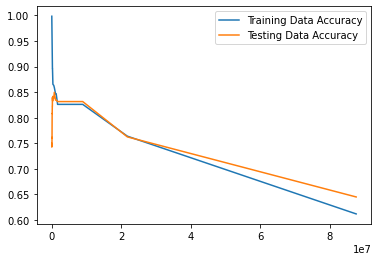

In [35]:
fig, ax = plt.subplots()
ax.plot(ccp_alpha_list, train_accuracy_list, label = "Training Data Accuracy")
ax.plot(ccp_alpha_list, test_accuracy_list, label = "Testing Data Accuracy")
ax.legend()

In [36]:
max_test = test_accuracy_list.index(max(test_accuracy_list))
max_test

904

In [37]:
best_ccp = ccp_alpha_list[max_test]
best_ccp

721680.445954578

In [38]:
decision_tree_model = DecisionTreeRegressor(ccp_alpha= best_ccp,random_state=11)

decision_tree_model.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=721680.445954578, random_state=11)

In [39]:
# Testing Accuracy
y_pred = decision_tree_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :", mse)
print("*"*50)

rmse = np.sqrt(mse)
print("RMSE :", rmse)
print("*"*50)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :", mae)
print("*"*50)

r2_value = r2_score(y_test, y_pred)
print("R2 Score :", r2_value)

MSE : 24057001.827663045
**************************************************
RMSE : 4904.793759951895
**************************************************
MAE : 2998.287106134118
**************************************************
R2 Score : 0.8496284944260787


In [40]:
# Training Accuracy
y_pred_train = decision_tree_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :", mse)
print("*"*50)

rmse = np.sqrt(mse)
print("RMSE :", rmse)
print("*"*50)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE :", mae)
print("*"*50)

r2_value = r2_score(y_train, y_pred_train)
print("R2 Score :", r2_value)

MSE : 20153971.949190762
**************************************************
RMSE : 4489.317537130868
**************************************************
MAE : 2691.833818406996
**************************************************
R2 Score : 0.8592068208170239


# Feature Selection Techniques

In [41]:
array = decision_tree_model.feature_importances_
array

array([0.10504453, 0.        , 0.17679971, 0.0058677 , 0.71228806,
       0.        , 0.        , 0.        , 0.        ])

<AxesSubplot:>

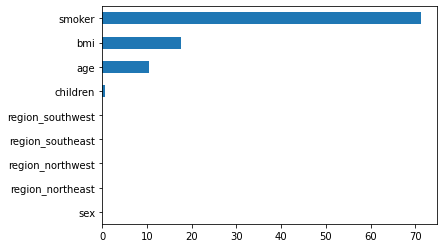

In [42]:
s1 = pd.Series(array * 100, index=x.columns)
s1.sort_values().plot(kind = "barh")

## Accuracy After CCP Prunning:

###  Training = 85.92%
### Tesing = 84.96% 

# Dictionary of label encoded columns

In [92]:
json_data={'sex':sex_values,
                          'smoker':smoker_values,
                          'column_names':list(x.columns)}
json_data

{'sex': {'male': 0, 'female': 1},
 'smoker': {'no': 1, 'yes': 0},
 'column_names': ['age',
  'sex',
  'bmi',
  'children',
  'smoker',
  'region_northeast',
  'region_northwest',
  'region_southeast',
  'region_southwest']}

In [94]:
# Saving label encoded dictionary in json file

with open("Project_data.json",'w') as f:
    json.dump(json_data,f)

In [95]:
# Saving the model

with open("medical_insurance_DecisionTreeRegression.pkl",'wb') as f:
    pickle.dump(decision_tree_model,f)

# Single user input Testing

In [96]:
age=29
sex='male'
bmi=26.9
children=0
smoker='no'
region='northwest'

region='region_' + region
region_index=list(x.columns).index(region)

In [97]:
test_array=np.zeros(x.shape[1])

test_array[0]=age
test_array[1]=json_data['sex'][sex]
test_array[2]=bmi
test_array[3]=children
test_array[4]=json_data['smoker'][smoker]
test_array[region_index]= 1

test_array

array([29. ,  0. , 26.9,  0. ,  1. ,  0. ,  1. ,  0. ,  0. ])

In [98]:
charges=round(decision_tree_model.predict([test_array])[0],2)
print("Predicted Insurance charge is Rs.",charges,"/- only")

Predicted Insurance charge is Rs. 3963.33 /- only
